In [70]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import torch

from skimage import exposure

In [71]:
# Directorio que contiene las subcarpetas numeradas
base_dir = 'C:/Users/jor14/Desktop/Not_treatment_worked_Nifti/'  # Cambia esto a la ruta de tu directorio base

In [72]:

# Crear una carpeta para guardar las imágenes y máscaras sintéticas
output_dir = 'synthetic_images'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # Elimina el directorio existente si ya existe
os.makedirs(output_dir)

In [73]:
# Función para aplicar ruido aleatorio
def add_random_noise(image_np, noise_level=0.1):
    noise = np.random.normal(loc=0, scale=noise_level, size=image_np.shape)
    return image_np + noise

In [74]:
# Función para ajustar brillo y contraste
def adjust_brightness_contrast(image_np, brightness_factor=1.0, contrast_factor=1.0):
    # Ajuste de brillo
    image_np = image_np * brightness_factor
    # Ajuste de contraste
    p2, p98 = np.percentile(image_np, (2, 98))
    image_np = exposure.rescale_intensity(image_np, in_range=(p2, p98)) * contrast_factor
    return np.clip(image_np, 0, 255)

In [75]:
# Función para aplicar flipping (volteo) aleatorio
def apply_random_flipping(image_np, mask_np):
    if np.random.rand() > 0.5:
        image_np = np.flip(image_np, axis=0)
        mask_np = np.flip(mask_np, axis=0)
    if np.random.rand() < 0.5:
        image_np = np.flip(image_np, axis=1)
        mask_np = np.flip(mask_np, axis=1)
    return image_np, mask_np

In [76]:
# Función para generar datos sintéticos
def generate_synthetic_image(image_np, mask_np):
    # Añadir ruido aleatorio
    noisy_image = add_random_noise(image_np)
    
    # Ajustar brillo y contraste
    brightness_factor = np.random.uniform(0.8, 1.2)  # Factor de brillo aleatorio
    contrast_factor = np.random.uniform(0.8, 1.2)    # Factor de contraste aleatorio
    final_image = adjust_brightness_contrast(noisy_image, brightness_factor, contrast_factor)
    
    # Aplicar flipping aleatorio
    final_image, final_mask = apply_random_flipping(final_image, mask_np)
    
    return final_image, final_mask


In [77]:
# Número de imágenes sintéticas a generar
num_original_images = 16
num_synthetic_images = 18  # Queremos generar 18 imágenes sintéticas

# Almacenar las imágenes originales y sus máscaras
original_images = []
original_masks = []

In [78]:
# Cargar las 16 imágenes originales y sus máscaras
for i in range(1, 17):
    folder_path = os.path.join(base_dir, f'{i:02d}')
    image_path = os.path.join(folder_path, 'Image.nii')
    mask_path = os.path.join(folder_path, 'Mask.nii')

    # Cargar imagen y máscara
    image = nib.load(image_path)
    mask = nib.load(mask_path)

    # Obtener los datos como arrays numpy
    image_data_np = image.get_fdata()
    mask_data_np = mask.get_fdata()

    # Convertir los arrays numpy a tensores PyTorch
    image_data_tensor = torch.from_numpy(image_data_np.astype(np.float32))
    mask_data_tensor = torch.from_numpy(mask_data_np.astype(np.float32))

    # Almacenar los tensores y las matrices afines en listas
    original_images.append((image_data_tensor, image.affine))
    original_masks.append((mask_data_tensor, mask.affine))


In [79]:
# Generar y guardar imágenes sintéticas y sus máscaras correspondientes
for i in range(1, num_synthetic_images + 1):
    # Seleccionar una imagen original al azar para generar una imagen sintética
    idx = (i - 1) % num_original_images
    original_image_tensor, affine_image = original_images[idx]
    original_mask_tensor, affine_mask = original_masks[idx]

    # Convertir tensores a arrays numpy
    original_image_np = original_image_tensor.numpy()
    original_mask_np = original_mask_tensor.numpy()

# Generar datos sintéticos para la imagen
    synthetic_image_np, synthetic_mask_np = generate_synthetic_image(original_image_np, original_mask_np)

    # La máscara se mantiene igual (sin transformaciones)
   
    # Crear subcarpeta para cada imagen sintética
    output_subdir = os.path.join(output_dir, f'{i:02d}')
    os.makedirs(output_subdir)

    # Crear imágenes NIfTI para los datos sintéticos
    synthetic_image = nib.Nifti1Image(synthetic_image_np, affine_image)
    synthetic_mask = nib.Nifti1Image(synthetic_mask_np, affine_mask)

    # Guardar las imágenes y máscaras sintéticas en la subcarpeta correspondiente
    nib.save(synthetic_image, os.path.join(output_subdir, 'Image.nii'))
    nib.save(synthetic_mask, os.path.join(output_subdir, 'Mask.nii'))

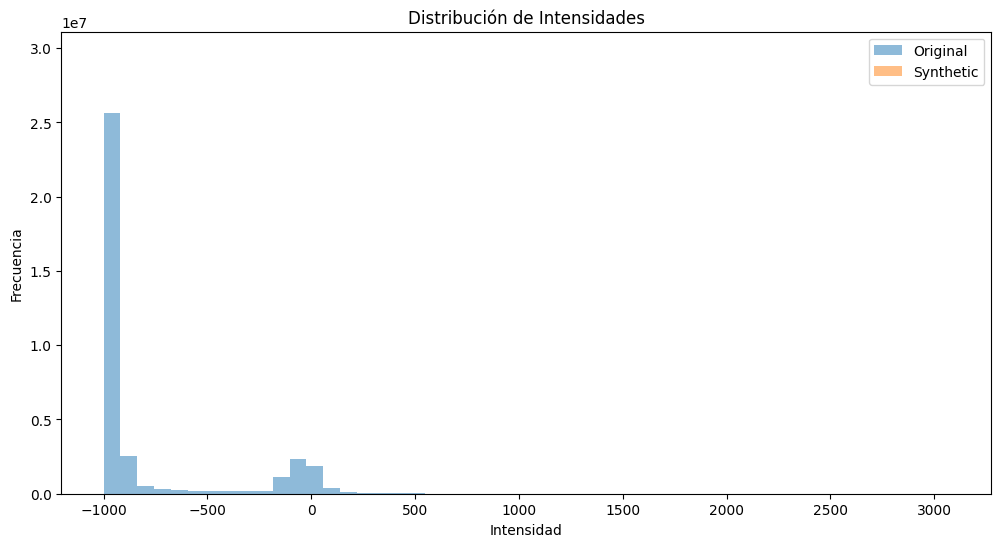

In [80]:
# Comparar distribuciones de las imágenes originales y sintéticas
original_sample = original_images[0][0].numpy().flatten()
synthetic_sample = synthetic_data_np.flatten()

plt.figure(figsize=(12, 6))
plt.hist(original_sample, bins=50, alpha=0.5, label='Original')
plt.hist(synthetic_sample, bins=50, alpha=0.5, label='Synthetic')
plt.legend(loc='upper right')
plt.title('Distribución de Intensidades')
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')
plt.show()